In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset, Subset, Dataset, random_split
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import sys
from PIL import Image
import pandas as pd
import os

Regressor_model

In [37]:
class ImageSensorDataset(Dataset):
    def __init__(self, folder_path, csv_path, transform=None):
        self.folder_path = folder_path
        self.csv_data = pd.read_csv(csv_path)
        self.transform = transform

    def __len__(self):
        return len(self.csv_data)

    def __getitem__(self, idx):
        filename = f"{idx}.jpg"
        image_path = os.path.join(self.folder_path, filename)
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        sensor_data = [float(x) for x in self.csv_data.iloc[idx, 1].split(',')]
        
        return image, torch.tensor(sensor_data, dtype=torch.float32)

In [38]:
transform = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor()
])

folder_path = r"C:\Users\susmi\Desktop\data_hybrid\main_cam_image"
csv_path = r"C:\Users\susmi\Desktop\data_hybrid\output.csv"

dataset = ImageSensorDataset(folder_path, csv_path, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, drop_last=True)

In [39]:
def show_image(image_tensor):
    image = image_tensor.permute(1, 2, 0)  # Change dimensions from (C, H, W) to (H, W, C)
    image = image.numpy()  
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Sensor Data 0: tensor([0.6667, 0.6656, 0.4294, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


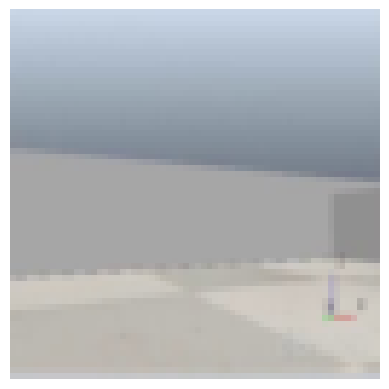

Sensor Data 1: tensor([0.6677, 0.6561, 0.3997, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


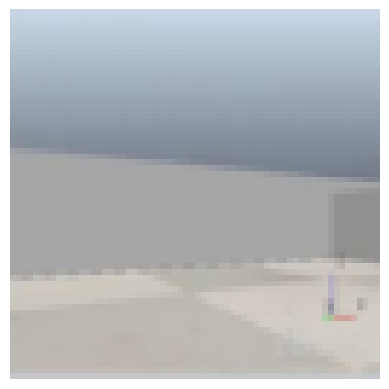

Sensor Data 2: tensor([0.6677, 0.6455, 0.3683, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


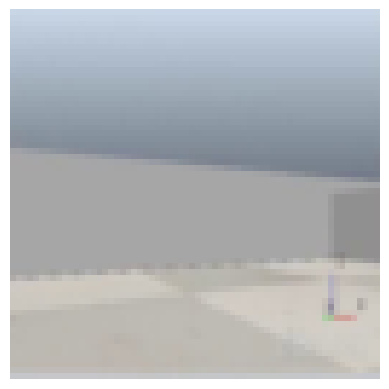

Sensor Data 3: tensor([0.6668, 0.6340, 0.3351, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


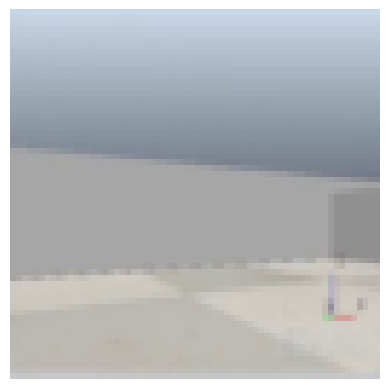

Sensor Data 4: tensor([0.6655, 0.6215, 0.3002, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


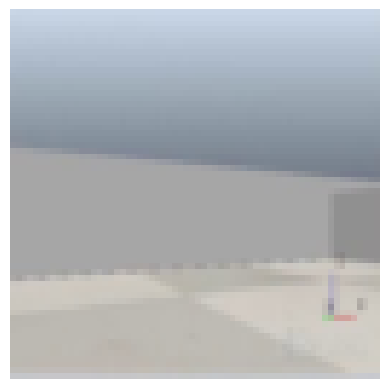

In [40]:
for i in range(5):
    image, sensor_data = dataset[i]
    print(f"Sensor Data {i}: {sensor_data}")
    show_image(image)

In [41]:
class CustomCNN(nn.Module):
    def __init__(self, input_channels=3, input_height=64, input_width=64):
        super(CustomCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.flattened_size = self._get_flattened_size(input_height, input_width)
        
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, 16)
        
    def _get_flattened_size(self, height, width):
        dummy_input = torch.zeros(1, 3, height, width)
        
        dummy_output = self.conv1(dummy_input)
        dummy_output = self.conv2(dummy_output)
        dummy_output = self.conv3(dummy_output)
        dummy_output = self.conv4(dummy_output)
        
        return int(torch.prod(torch.tensor(dummy_output.shape[1:])))
        
    def forward(self, x):
    
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x) 
        
        return x

In [46]:
def initialize_weights(model):
    for name, param in model.named_parameters():
        if param.dim() > 1: 
            nn.init.xavier_normal_(param)
        elif 'bias' in name:
            nn.init.constant_(param, 0)
model = CustomCNN()
initialize_weights(model)

In [45]:
model = CustomCNN()
data = np.random.randn(1, 3, 64, 64)
data_tensor = torch.tensor(data, dtype=torch.float32)
summary(model, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,136
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 16, 16]          65,600
       BatchNorm2d-4           [-1, 64, 16, 16]             128
            Conv2d-5             [-1, 64, 8, 8]          65,600
       BatchNorm2d-6             [-1, 64, 8, 8]             128
            Conv2d-7             [-1, 64, 4, 4]          65,600
       BatchNorm2d-8             [-1, 64, 4, 4]             128
            Linear-9                  [-1, 256]         262,400
           Linear-10                   [-1, 16]           4,112
Total params: 466,960
Trainable params: 466,960
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 1.33
Params size (MB): 1.78
Estimated T

In [75]:
output = model(data_tensor)

input: torch.Size([1, 3, 64, 64])
conv1: torch.Size([1, 64, 32, 32])
conv2: torch.Size([1, 64, 16, 16])
conv3: torch.Size([1, 64, 8, 8])
conv4: torch.Size([1, 64, 4, 4])
unit: torch.Size([1, 1024])
layer1: torch.Size([1, 256])
output: torch.Size([1, 16])


In [47]:

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
lossfun = nn.MSELoss()

In [48]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    model.train()
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        
        for images, target in train_loader:
            
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, target)
            
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item() * images.size(0)
        
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        model.eval()
        running_test_loss = 0.0
        
        with torch.no_grad():
            for images, target in test_loader:
                output = model(images)
                loss = criterion(output, target)
                running_test_loss += loss.item() * images.size(0)
        
        epoch_test_loss = running_test_loss / len(test_loader.dataset)
        test_losses.append(epoch_test_loss)
        
        model.train()  
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')
    
    return model, train_losses, test_losses

In [49]:
num_epochs = 100
trained_model, train_losses, test_losses = train_model(model, train_loader, test_loader, lossfun, optimizer, num_epochs)

Epoch 1/100, Train Loss: 0.2062, Test Loss: 0.0956
Epoch 2/100, Train Loss: 0.0485, Test Loss: 0.1532
Epoch 3/100, Train Loss: 0.0285, Test Loss: 0.0848
Epoch 4/100, Train Loss: 0.0202, Test Loss: 0.0362
Epoch 5/100, Train Loss: 0.0163, Test Loss: 0.0191
Epoch 6/100, Train Loss: 0.0140, Test Loss: 0.0149
Epoch 7/100, Train Loss: 0.0119, Test Loss: 0.0134
Epoch 8/100, Train Loss: 0.0106, Test Loss: 0.0121
Epoch 9/100, Train Loss: 0.0104, Test Loss: 0.0116
Epoch 10/100, Train Loss: 0.0094, Test Loss: 0.0100
Epoch 11/100, Train Loss: 0.0083, Test Loss: 0.0091
Epoch 12/100, Train Loss: 0.0075, Test Loss: 0.0086
Epoch 13/100, Train Loss: 0.0073, Test Loss: 0.0081
Epoch 14/100, Train Loss: 0.0066, Test Loss: 0.0074
Epoch 15/100, Train Loss: 0.0066, Test Loss: 0.0074
Epoch 16/100, Train Loss: 0.0064, Test Loss: 0.0073
Epoch 17/100, Train Loss: 0.0061, Test Loss: 0.0069
Epoch 18/100, Train Loss: 0.0057, Test Loss: 0.0064
Epoch 19/100, Train Loss: 0.0051, Test Loss: 0.0060
Epoch 20/100, Train L

[]

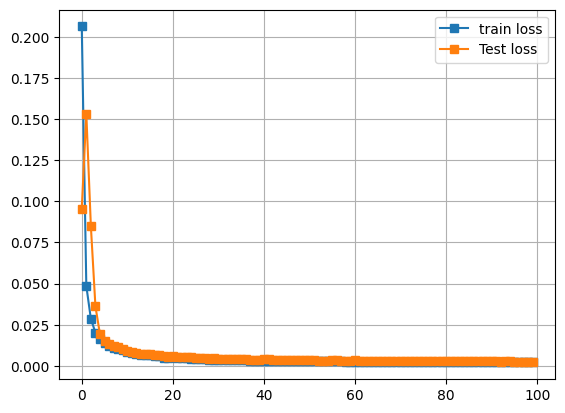

In [50]:
#weight initialization
plt.plot(train_losses, 's-')
plt.plot(test_losses, 's-')
plt.legend(['train loss', 'Test loss'])
plt.grid()
plt.plot()

[]

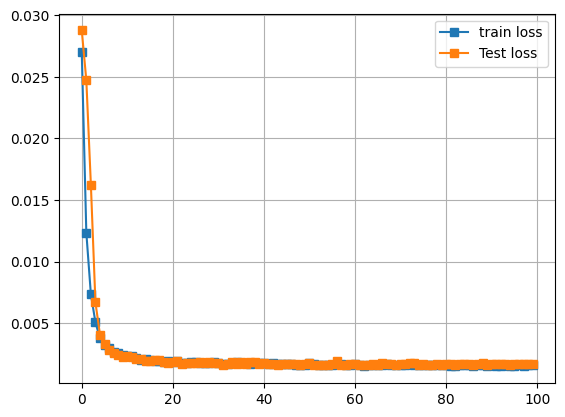

In [12]:
plt.plot(train_losses, 's-')
plt.plot(test_losses, 's-')
plt.legend(['train loss', 'Test loss'])
plt.grid()
plt.plot()

[]

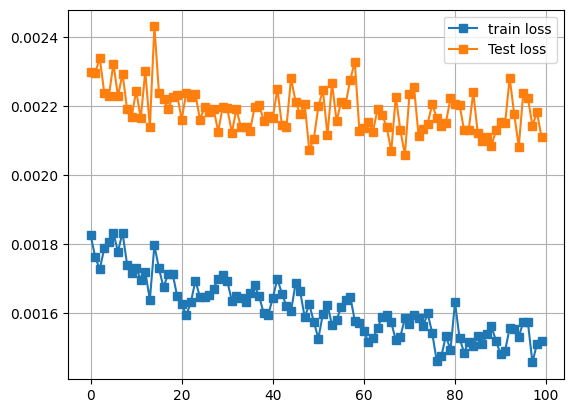

In [128]:
#Without batchnorm
plt.plot(train_losses, 's-')
plt.plot(test_losses, 's-')
plt.legend(['train loss', 'Test loss'])
plt.grid()
plt.plot()

classification_model

In [86]:
class ImageSensorDataset(Dataset):
    def __init__(self, folder_path, csv_path, transform=None):
        self.folder_path = folder_path
        self.csv_data = pd.read_csv(csv_path)
        self.transform = transform

    def __len__(self):
        return len(self.csv_data)

    def __getitem__(self, idx):
        filename = f"{idx}.jpg"
        image_path = os.path.join(self.folder_path, filename)
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        sensor_data = [float(x) for x in self.csv_data.iloc[idx, 1].split(',')]
        label = 0 if all(x == 0.0 for x in sensor_data) else 1
        
        return image, torch.tensor(label, dtype=torch.float32)

In [87]:
transform = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

folder_path = r"C:\Users\susmi\Desktop\data_hybrid\main_cam_image"
csv_path = r"C:\Users\susmi\Desktop\data_hybrid\output.csv"

dataset = ImageSensorDataset(folder_path, csv_path, transform=transform)

In [88]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, drop_last=True)

In [89]:
class CustomCNN(nn.Module):
    def __init__(self, input_channels=3, input_height=64, input_width=64):
        super(CustomCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.flattened_size = self._get_flattened_size(input_height, input_width)
        
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, 1)  
        
    def _get_flattened_size(self, height, width):
        dummy_input = torch.zeros(1, 3, height, width)
        
        dummy_output = self.conv1(dummy_input)
        dummy_output = self.conv2(dummy_output)
        dummy_output = self.conv3(dummy_output)
        dummy_output = self.conv4(dummy_output)
        
        return int(torch.prod(torch.tensor(dummy_output.shape[1:])))
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  
        
        return x

In [90]:
def initialize_weights(model):
    for name, param in model.named_parameters():
        if param.dim() > 1: 
            nn.init.xavier_normal_(param)
        elif 'bias' in name:
            nn.init.constant_(param, 0)
model = CustomCNN()
initialize_weights(model)

In [91]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
lossfun = nn.BCEWithLogitsLoss()

In [92]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    model.train()
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        
        for images, labels in train_loader:
            
            optimizer.zero_grad()
            output = model(images).squeeze(1)  
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item() * images.size(0)
        
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        model.eval()
        running_test_loss = 0.0
        
        with torch.no_grad():
            for images, labels in test_loader:
                output = model(images).squeeze(1) 
                loss = criterion(output, labels)
                running_test_loss += loss.item() * images.size(0)
        
        epoch_test_loss = running_test_loss / len(test_loader.dataset)
        test_losses.append(epoch_test_loss)
        
        model.train()  
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')
    
    return model, train_losses, test_losses

In [93]:
num_epochs = 50
trained_model, train_losses, test_losses = train_model(model, train_loader, test_loader, lossfun, optimizer, num_epochs)

Epoch 1/50, Train Loss: 0.4113, Test Loss: 0.6391
Epoch 2/50, Train Loss: 0.1798, Test Loss: 0.6443
Epoch 3/50, Train Loss: 0.0980, Test Loss: 0.2337
Epoch 4/50, Train Loss: 0.0656, Test Loss: 0.0785
Epoch 5/50, Train Loss: 0.0480, Test Loss: 0.0532
Epoch 6/50, Train Loss: 0.0363, Test Loss: 0.0430
Epoch 7/50, Train Loss: 0.0335, Test Loss: 0.0371
Epoch 8/50, Train Loss: 0.0265, Test Loss: 0.0295
Epoch 9/50, Train Loss: 0.0217, Test Loss: 0.0221
Epoch 10/50, Train Loss: 0.0209, Test Loss: 0.0263
Epoch 11/50, Train Loss: 0.0216, Test Loss: 0.0223
Epoch 12/50, Train Loss: 0.0226, Test Loss: 0.0195
Epoch 13/50, Train Loss: 0.0188, Test Loss: 0.0157
Epoch 14/50, Train Loss: 0.0142, Test Loss: 0.0153
Epoch 15/50, Train Loss: 0.0103, Test Loss: 0.0122
Epoch 16/50, Train Loss: 0.0105, Test Loss: 0.0134
Epoch 17/50, Train Loss: 0.0113, Test Loss: 0.0167
Epoch 18/50, Train Loss: 0.0120, Test Loss: 0.0082
Epoch 19/50, Train Loss: 0.0103, Test Loss: 0.0104
Epoch 20/50, Train Loss: 0.0091, Test Lo

[]

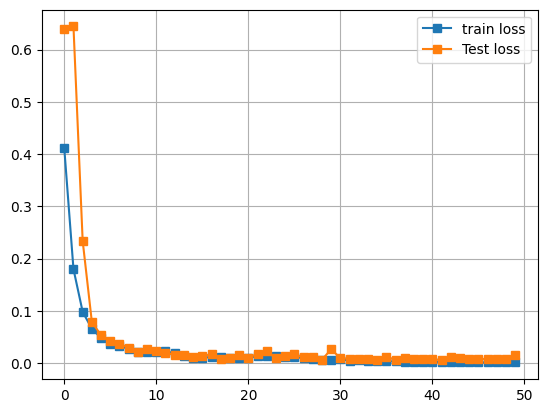

In [94]:
#with weight initialization
plt.plot(train_losses, 's-')
plt.plot(test_losses, 's-')
plt.legend(['train loss', 'Test loss'])
plt.grid()
plt.plot()

[]

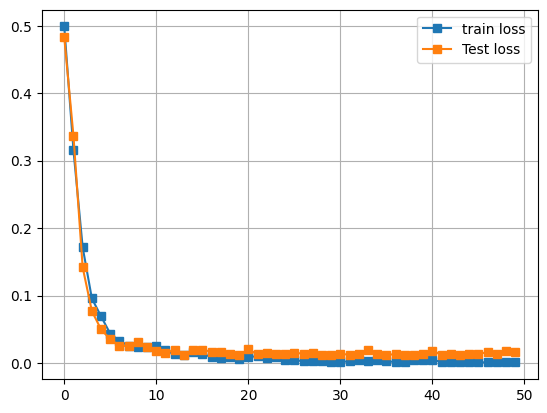

In [20]:
plt.plot(train_losses, 's-')
plt.plot(test_losses, 's-')
plt.legend(['train loss', 'Test loss'])
plt.grid()
plt.plot()

[]

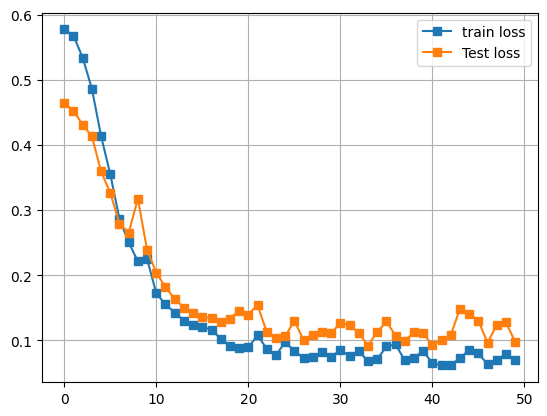

In [140]:
#without batchnorm
plt.plot(train_losses, 's-')
plt.plot(test_losses, 's-')
plt.legend(['train loss', 'Test loss'])
plt.grid()
plt.plot()

Multi-task model

In [95]:
class ImageSensorDataset(Dataset):
    def __init__(self, folder_path, csv_path, transform=None):
        self.folder_path = folder_path
        self.csv_data = pd.read_csv(csv_path)
        self.transform = transform

    def __len__(self):
        return len(self.csv_data)

    def __getitem__(self, idx):
        filename = f"{idx}.jpg"
        image_path = os.path.join(self.folder_path, filename)
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        sensor_data = [float(x) for x in self.csv_data.iloc[idx, 1].split(',')]
        label = 0 if all(x == 0.0 for x in sensor_data) else 1
        
        return image, torch.tensor(sensor_data, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

In [96]:
transform = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

folder_path = r"C:\Users\susmi\Desktop\data_hybrid\main_cam_image"
csv_path = r"C:\Users\susmi\Desktop\data_hybrid\output.csv"

dataset = ImageSensorDataset(folder_path, csv_path, transform=transform)

In [97]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, drop_last=True)

In [98]:
class MultiTaskCNN(nn.Module):
    def __init__(self, input_channels=3, input_height=64, input_width=64):
        super(MultiTaskCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.flattened_size = self._get_flattened_size(input_height, input_width)
        
        self.shared_fc = nn.Linear(self.flattened_size, 256)
        
        self.regression_fc = nn.Linear(256, 16)  
        self.classification_fc = nn.Linear(256, 1)  
        
    def _get_flattened_size(self, height, width):
        dummy_input = torch.zeros(1, 3, height, width)
        
        dummy_output = self.conv1(dummy_input)
        dummy_output = self.conv2(dummy_output)
        dummy_output = self.conv3(dummy_output)
        dummy_output = self.conv4(dummy_output)
        
        return int(torch.prod(torch.tensor(dummy_output.shape[1:])))
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.shared_fc(x))
        
        regression_output = self.regression_fc(x)
        classification_output = self.classification_fc(x)
        
        return regression_output, classification_output

In [102]:
def initialize_weights(model):
    for name, param in model.named_parameters():
        if param.dim() > 1: 
            nn.init.xavier_normal_(param)
        elif 'bias' in name:
            nn.init.constant_(param, 0)
model = MultiTaskCNN()
initialize_weights(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
regression_loss_fn = nn.MSELoss()
classification_loss_fn = nn.BCEWithLogitsLoss()

In [103]:
def train_model(model, train_loader, test_loader, regression_loss_fn, classification_loss_fn, optimizer, num_epochs, alpha=1.0):
    model.train()
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        
        for images, regression_target, classification_target in train_loader:
            
            optimizer.zero_grad()
            regression_output, classification_output = model(images)
            regression_loss = regression_loss_fn(regression_output, regression_target)
            classification_loss = classification_loss_fn(classification_output.squeeze(1), classification_target)
            loss = regression_loss + alpha * classification_loss
            
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item() * images.size(0)
        
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        model.eval()
        running_test_loss = 0.0
        
        with torch.no_grad():
            for images, regression_target, classification_target in test_loader:
                regression_output, classification_output = model(images)
                regression_loss = regression_loss_fn(regression_output, regression_target)
                classification_loss = classification_loss_fn(classification_output.squeeze(1), classification_target)
                loss = regression_loss + alpha * classification_loss
                running_test_loss += loss.item() * images.size(0)
        
        epoch_test_loss = running_test_loss / len(test_loader.dataset)
        test_losses.append(epoch_test_loss)
        
        model.train()  
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')
    
    return model, train_losses, test_losses

In [104]:
num_epochs = 100
trained_model, train_losses, test_losses = train_model(model, train_loader, test_loader, regression_loss_fn, classification_loss_fn, optimizer, num_epochs)

Epoch 1/100, Train Loss: 0.6452, Test Loss: 0.7286
Epoch 2/100, Train Loss: 0.3324, Test Loss: 0.7787
Epoch 3/100, Train Loss: 0.2249, Test Loss: 0.4726
Epoch 4/100, Train Loss: 0.1633, Test Loss: 0.1917
Epoch 5/100, Train Loss: 0.1303, Test Loss: 0.1435
Epoch 6/100, Train Loss: 0.1073, Test Loss: 0.1142
Epoch 7/100, Train Loss: 0.0912, Test Loss: 0.0887
Epoch 8/100, Train Loss: 0.0814, Test Loss: 0.0755
Epoch 9/100, Train Loss: 0.0697, Test Loss: 0.0638
Epoch 10/100, Train Loss: 0.0621, Test Loss: 0.0573
Epoch 11/100, Train Loss: 0.0541, Test Loss: 0.0534
Epoch 12/100, Train Loss: 0.0546, Test Loss: 0.0562
Epoch 13/100, Train Loss: 0.0455, Test Loss: 0.0463
Epoch 14/100, Train Loss: 0.0442, Test Loss: 0.0562
Epoch 15/100, Train Loss: 0.0421, Test Loss: 0.0411
Epoch 16/100, Train Loss: 0.0387, Test Loss: 0.0375
Epoch 17/100, Train Loss: 0.0352, Test Loss: 0.0349
Epoch 18/100, Train Loss: 0.0302, Test Loss: 0.0327
Epoch 19/100, Train Loss: 0.0299, Test Loss: 0.0317
Epoch 20/100, Train L

[]

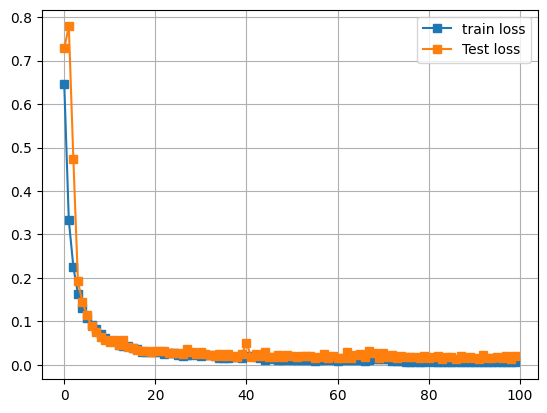

In [105]:
#with weight initialization and atchnorm
plt.plot(train_losses, 's-')
plt.plot(test_losses, 's-')
plt.legend(['train loss', 'Test loss'])
plt.grid()
plt.plot()

[]

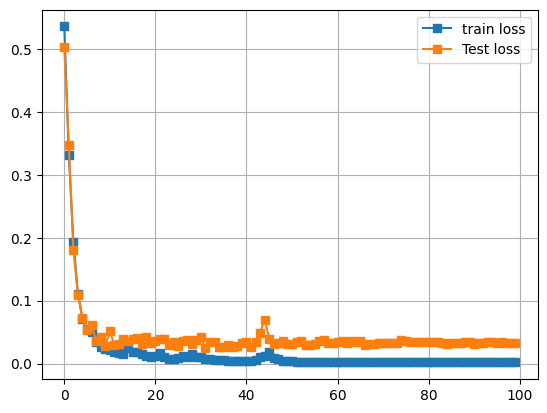

In [36]:
plt.plot(train_losses, 's-')
plt.plot(test_losses, 's-')
plt.legend(['train loss', 'Test loss'])
plt.grid()
plt.plot()

[]

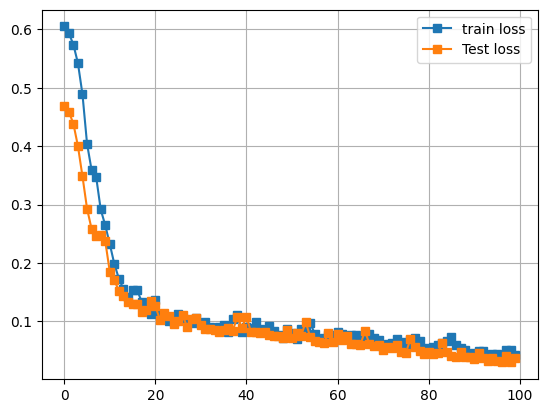

In [151]:
#without batchnorm
plt.plot(train_losses, 's-')
plt.plot(test_losses, 's-')
plt.legend(['train loss', 'Test loss'])
plt.grid()
plt.plot()